In [1]:
import numpy as np

### Code from Tanner

In [65]:
def compute_gain(sound, fs, min_db=-80.0, mode='A_weighting'):
    """Helper function for mix"""
    if fs == 16000:
        n_fft = 2048
    elif fs == 44100:
        n_fft = 4096
    else:
        raise Exception('Invalid fs {}'.format(fs))
    stride = n_fft // 2

    gain = []
    for i in xrange(0, len(sound) - n_fft + 1, stride):
        if mode == 'RMSE':
            g = np.mean(sound[i: i + n_fft] ** 2)
        elif mode == 'A_weighting':
            spec = np.fft.rfft(np.hanning(n_fft + 1)[:-1] * sound[i: i + n_fft])
            power_spec = np.abs(spec) ** 2
            a_weighted_spec = power_spec * np.power(10, a_weight(fs, n_fft) / 10)
            g = np.sum(a_weighted_spec)
        else:
            raise Exception('Invalid mode {}'.format(mode))
        gain.append(g)

    gain = np.array(gain)
    gain = np.maximum(gain, np.power(10, min_db / 10))
    gain_db = 10 * np.log10(gain)

    return gain_db

def mix(sound1, sound2, r, fs=44100):
    gain1 = np.max(compute_gain(sound1, fs))  # Decibel
    gain2 = np.max(compute_gain(sound2, fs))
    t = 1.0 / (1 + np.power(10, (gain1 - gain2) / 20.) * (1 - r) / r)
    sound = ((sound1 * t + sound2 * (1 - t)) / np.sqrt(t ** 2 + (1 - t) ** 2))

    return sound



def shift_sound(sound, max_len=220500):
    '''Helper function, randomly shift a sound and make it full length'''
    full_sound = np.zeros(max_len)
    length = len(sound)
    start = np.random.randint(max_len - length)
    end = start + length
    full_sound[start:end] = sound
    
    return full_sound


def shuffle_mix(sound1, sound2, r, fs=44100, max_len=220500):
    '''Shift short signals and pad so they are full length
       Shuffle one of the sounds then mix the two
    '''
    # If sounds are not full length: shift randomly within full interval
    if len(sound1) < max_len:
        sound1 = shift_sound(sound1, max_len)
    if len(sound2) < max_len:
        sound1 = shift_sound(sound2, max_len)
    
    # Get suffled order
    order = list(range(5))
    np.random.shuffle(order)
    sound1_shuffle = np.zeros(max_len)
    
    # shuffle sound1
    for i in order:
        sound1_shuffle[i*fs:i*fs+fs] = sound1[order[i]*fs:order[i]*fs+fs]
    
    return mix(sound1_shuffle, sound2, r)

def sliding_mix(sound1, sound2, r, fs=44100, max_len=220500, shift_limit=2*44100):
    '''Shift short signals and pad so they are full length
       Slide + pad the sounds (in opposite directions) then mix
    '''
    # make sure shift_limit is less than tolerance
    if shift_limit > 3*220500:
        raise ValueError("Cannot shift by more than 2 seconds") # should depend on shortest sound
    
    # If sounds are not full length: shift randomly within full interval
    if len(sound1) < max_len:
        sound1 = shift_sound(sound1, max_len)
    if len(sound2) < max_len:
        sound1 = shift_sound(sound2, max_len)
    
    shift_amt = np.random.randint(shift_limit) + 1 # 1 <= shift_amt <= 3 
    
    # pad sound1 on left by shift_amt; sound 2 on right by shift_amt
    cut_off = int(shift_amt/2)
    padding = np.zeros(shift_amt)
    sound1_changed = np.insert(sound1,0,padding)[cut_off:cut_off+max_len]
    sound2_changed = np.insert(sound2,len(sound2)-1, padding)[cut_off:cut_off+max_len]
    
    return mix(sound1_changed, sound2_changed, r)


In [3]:
# Load file
wav44 = np.load('wav50_44.npz')
list_of_audio_data = wav44['fold1'].item()['sounds']

In [7]:
import matplotlib.pyplot as plt

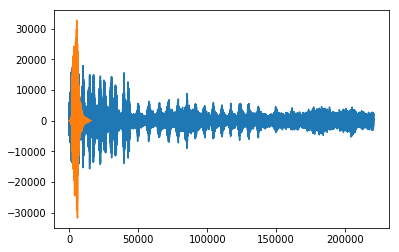

In [13]:
plt.plot(list_of_audio_data[1])
plt.plot(list_of_audio_data[0])

In [15]:
wav44['fold1'].item()['labels'][0]

0